# Stroke Prediction


In [1]:
#Standart Bibliotheken
import pandas as pd
import seaborn as sns
import scipy
import numpy as np
import matplotlib.pyplot as plt
#Algorithmen
from sklearn.ensemble import RandomForestClassifier #durchgeführt
from sklearn.svm import SVC #durchgeführt
from sklearn.neural_network import MLPClassifier #durchgeführt
from sklearn.neighbors import KNeighborsClassifier #durchgeführt
#Daten Preparation und Evaluation
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from joblib import dump
%matplotlib inline

### Informationen über den Datensatz

In [2]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [4]:
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

### Bereinigung der Daten

In [5]:
#fehlende BMI mit MEAN
bmi_mean = np.mean(df['bmi'])
print("MEAN:\t",bmi_mean)

MEAN:	 28.893236911794666


In [6]:
#Fehlende BMI werte mit MEAN auffüllen
df['bmi'] = df['bmi'].fillna(bmi_mean)
#Spalte Age in int64 umwandeln
df['age'] = df['age'].apply(lambda x: round(x))
#Spalte id löschen
df = df.drop(columns=['id'])


In [7]:
# Untersuchung der Kategorialen Spalten
print("Smoking Status:\n{}".format(df["smoking_status"].value_counts()))
print("\n\nGender:\n{}".format(df["gender"].value_counts()))
print("\n\nWork Type:\n{}".format(df["work_type"].value_counts()))
print("\n\nResidence Type:\n{}".format(df["Residence_type"].value_counts()))

Smoking Status:
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64


Gender:
Female    2994
Male      2115
Other        1
Name: gender, dtype: int64


Work Type:
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64


Residence Type:
Urban    2596
Rural    2514
Name: Residence_type, dtype: int64


In [8]:
#Zusammenfügen von "formerly smoked" mit "smoked"
df['smoking_status'] = df['smoking_status'].apply(lambda x: x.replace('formerly smoked', 'smokes'))
df['smoking_status'].value_counts()

never smoked    1892
smokes          1674
Unknown         1544
Name: smoking_status, dtype: int64

In [9]:
# "Other" wird aus der Spalte "Gender" gelöscht
indexDrop = (df[df['gender'] == "Other"]).index
df.drop(indexDrop, inplace=True)
df['gender'].value_counts()

Female    2994
Male      2115
Name: gender, dtype: int64

In [10]:
df[df["work_type"] == "Never_worked"]["age"].min()

13

In [11]:
df[df["work_type"] == "children"]["age"].max()

16

In [12]:
df.loc[df["age"] <= 16, "work_type"] = "children"

In [13]:
df[df["work_type"] != "children"]["age"].min()

17

In [14]:
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000
mean,43.229986,0.097475,0.054022,106.140399,28.894508,0.048738
std,22.613660,0.296633,0.226084,45.285004,7.698235,0.215340
min,0.000000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.240000,23.800000,0.000000
50%,45.000000,0.000000,0.000000,91.880000,28.400000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,32.800000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


## Visualisierung der Daten
### mit bezug auf den gesamten Datensatz

Text(0.5, 1.0, 'Allgemeine Anzahl von Schlaganfällen abhängig vom Geschlecht')

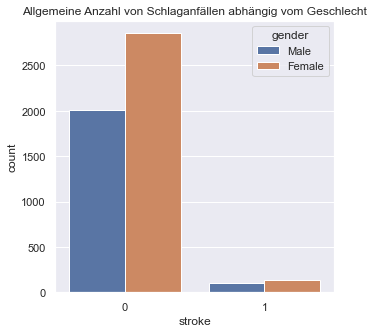

In [15]:
sns.set(style="darkgrid")
plt.figure(figsize=(5, 5))
GenderOnStroke = sns.countplot(x="stroke", hue="gender", data=df)
GenderOnStroke.set_title("Allgemeine Anzahl von Schlaganfällen abhängig vom Geschlecht")

0    4611
1     498
Name: hypertension, dtype: int64


Text(0.5, 1.0, 'Anzahl von Schlaganfällen mit Abhängikeit von Bluthochdruck')

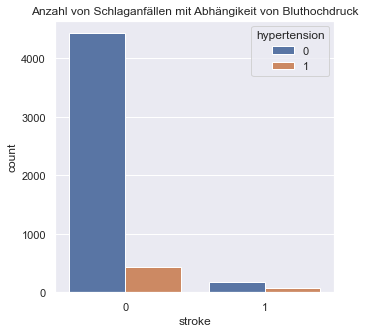

In [16]:
plt.figure(figsize=(5, 5))
hypertensionOnStrokeOnly = sns.countplot(x="stroke", hue="hypertension", data=df)
print(df.hypertension.value_counts())
hypertensionOnStrokeOnly.set_title("Anzahl von Schlaganfällen mit Abhängikeit von Bluthochdruck")

Text(0.5, 1.0, 'Anzahl von Männern und Frauen abhängig von Bluthochdruck')

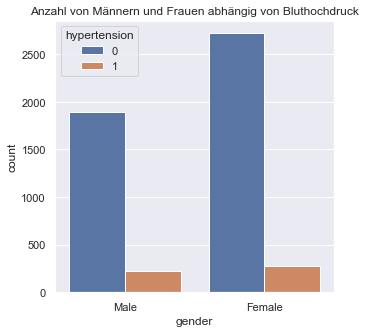

In [17]:
plt.figure(figsize=(5, 5))
hypertension_GenderOnStrokeOnly = sns.countplot(x="gender", hue="hypertension", data=df)
hypertension_GenderOnStrokeOnly.set_title("Anzahl von Männern und Frauen abhängig von Bluthochdruck")

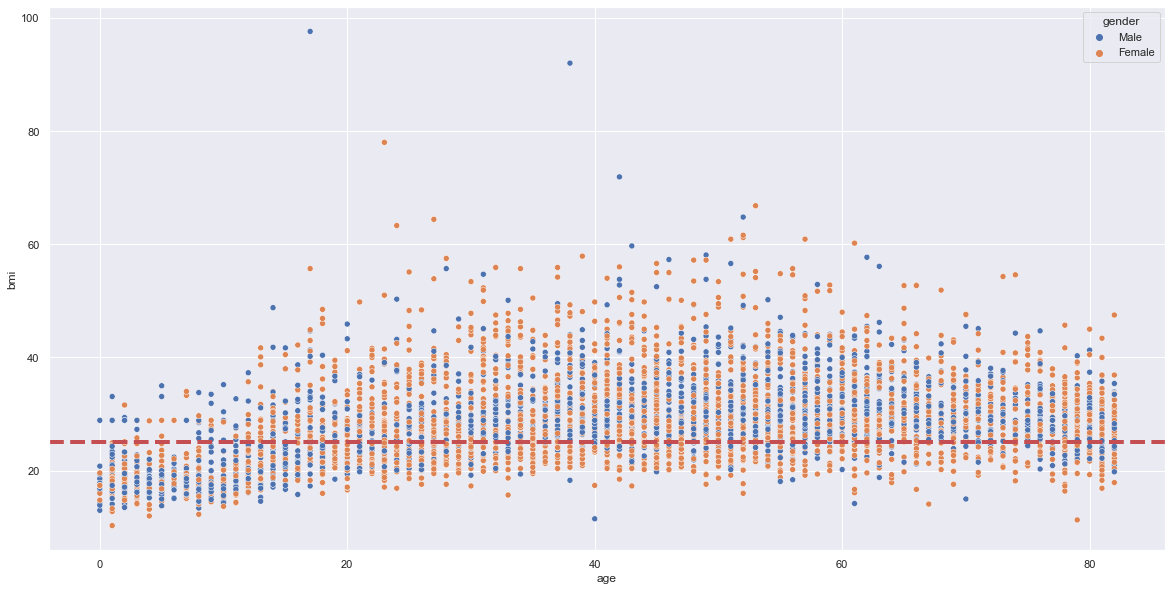

In [18]:
fig = plt.figure(figsize=(20,10))
graph = sns.scatterplot(data=df, x="age", y="bmi", hue='gender')
graph.axhline(y= 25, linewidth=4, color='r', linestyle= '--')
plt.show()

Urban    2596
Rural    2513
Name: Residence_type, dtype: int64


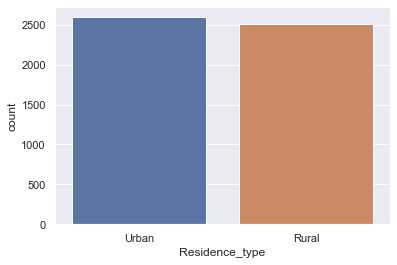

In [19]:
resident = sns.countplot(x="Residence_type", data=df)
print(df.Residence_type.value_counts())
plt.show()

Private          2839
Self-employed     810
children          796
Govt_job          654
Never_worked       10
Name: work_type, dtype: int64


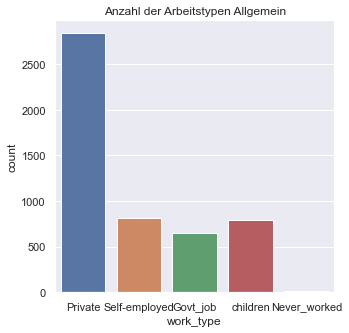

In [20]:
plt.figure(figsize=(5, 5))
work_typeOnStroke = sns.countplot(x="work_type", data=df)
print(df.work_type.value_counts())
work_typeOnStroke.set_title("Anzahl der Arbeitstypen Allgemein")
plt.show()

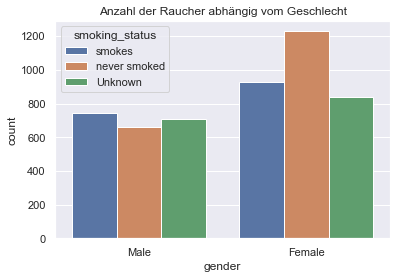

In [21]:
smoke = sns.countplot(x="gender",hue="smoking_status", data=df)
smoke.set_title("Anzahl der Raucher abhängig vom Geschlecht")
plt.show()

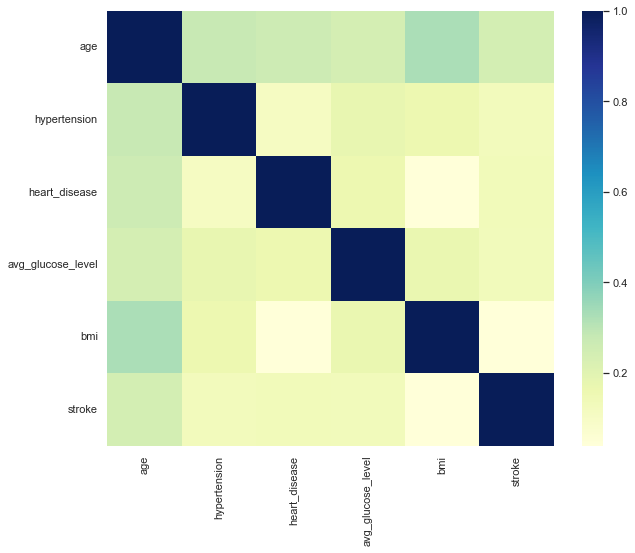

In [22]:
corr = df.corr()
f, ax = plt.subplots(figsize=(10, 8))
corr_vis = sns.heatmap(corr,cmap="YlGnBu")
plt.show()

In [23]:
df.corr()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
age,1.000000,0.276366,0.263776,0.238331,0.325859,0.245225
hypertension,0.276366,1.000000,0.108292,0.174540,0.160147,0.127891
heart_disease,0.263776,0.108292,1.000000,0.161907,0.038862,0.134905
avg_glucose_level,0.238331,0.174540,0.161907,1.000000,0.168910,0.131991
bmi,0.325859,0.160147,0.038862,0.168910,1.000000,0.038912
stroke,0.245225,0.127891,0.134905,0.131991,0.038912,1.000000


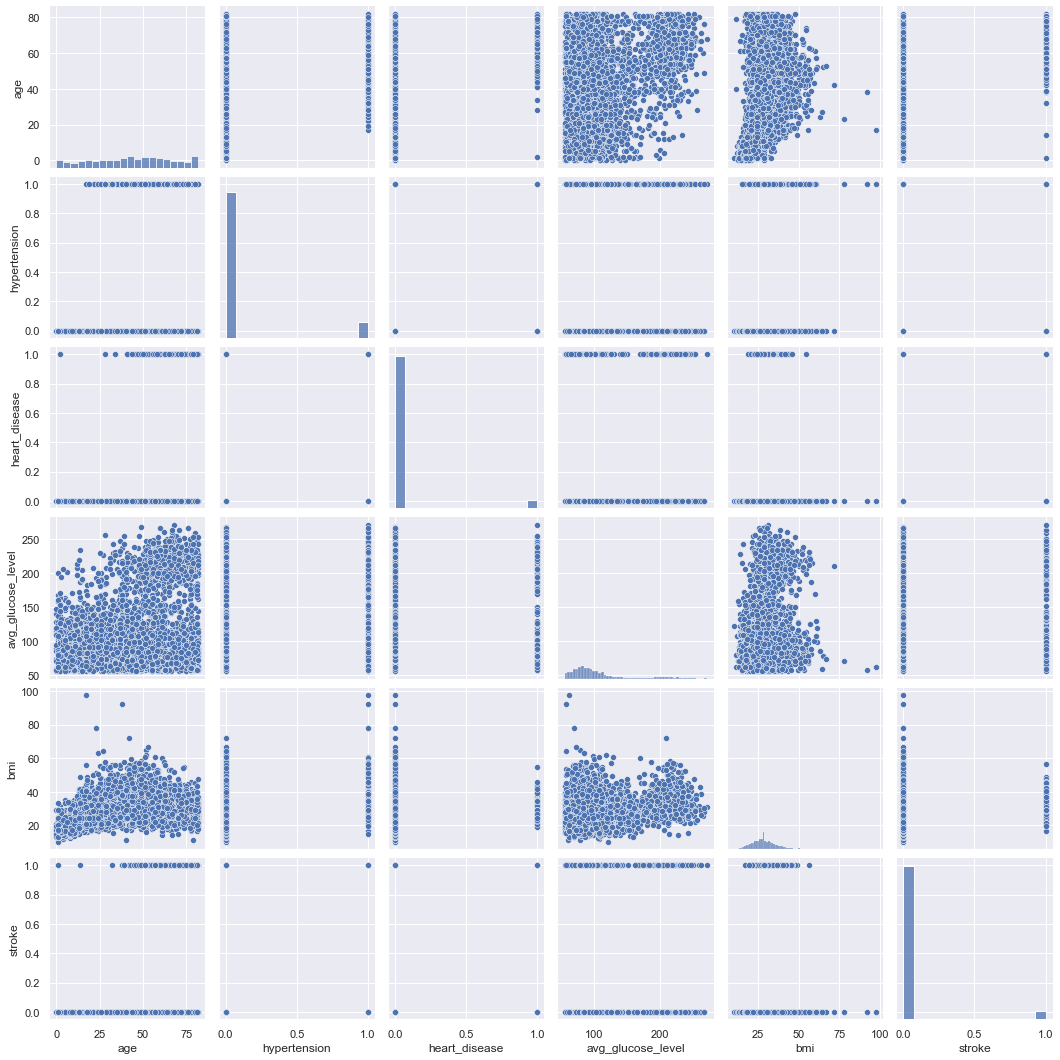

In [24]:
sns.pairplot(df)
plt.show()

### mit bezug auf den Datensatz : nur Schlaganfall

Female    141
Male      108
Name: gender, dtype: int64


Text(0.5, 1.0, 'Anzahl von Schlaganfällen abhängig vom Geschlecht')

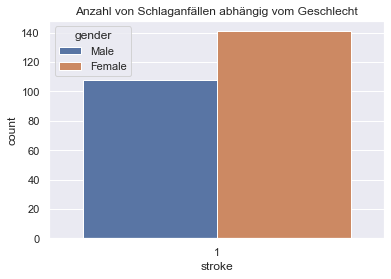

In [25]:
stroke_yes = df[df['stroke'] == 1]
GenderOnStrokeOnly = sns.countplot(x="stroke", hue="gender", data=stroke_yes)
print(stroke_yes.gender.value_counts())
GenderOnStrokeOnly.set_title("Anzahl von Schlaganfällen abhängig vom Geschlecht")

Text(0.5, 1.0, 'Anzahl der Schlaganfälle abhängig vom Alter')

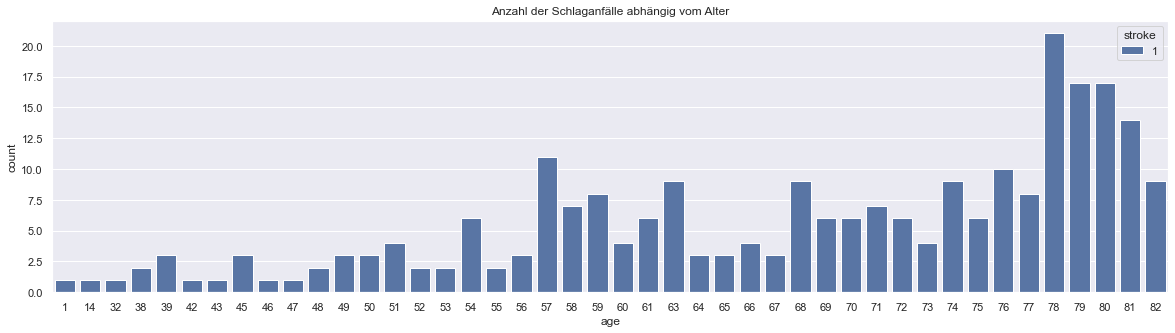

In [26]:
#stroke_no = df[df["stroke"] == 0]
f, ax = plt.subplots(figsize=(20, 5))
ageOnStroke = sns.countplot(x="age", hue="stroke", data=stroke_yes)
ageOnStroke.set_title("Anzahl der Schlaganfälle abhängig vom Alter")

Text(0.5, 1.0, 'Anzahl der Schlaganfälle abhängig vom Alter und Geschlecht')

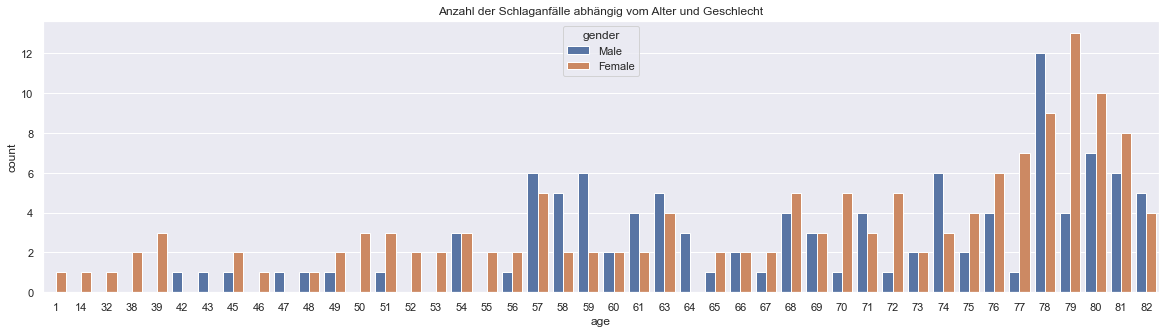

In [27]:
f, ax = plt.subplots(figsize=(20, 5))
ageOnStroke = sns.countplot(x="age", hue="gender", data=stroke_yes)
ageOnStroke.set_title("Anzahl der Schlaganfälle abhängig vom Alter und Geschlecht")

0    183
1     66
Name: hypertension, dtype: int64


Text(0.5, 1.0, 'Anzahl von Schlaganfällen mit Abhängikeit von Bluthochdruck')

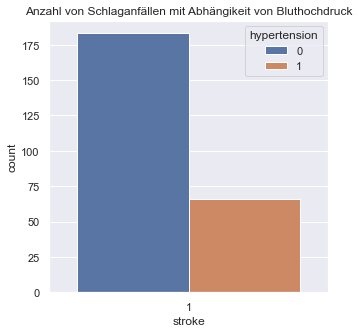

In [28]:
plt.figure(figsize=(5, 5))
hypertensionOnStrokeOnly = sns.countplot(x="stroke", hue="hypertension", data=stroke_yes)
print(stroke_yes.hypertension.value_counts())
hypertensionOnStrokeOnly.set_title("Anzahl von Schlaganfällen mit Abhängikeit von Bluthochdruck")

Text(0.5, 1.0, 'Anzahl von Männern und Frauen mit Schlaganfall abhängig von Bluthochdruck')

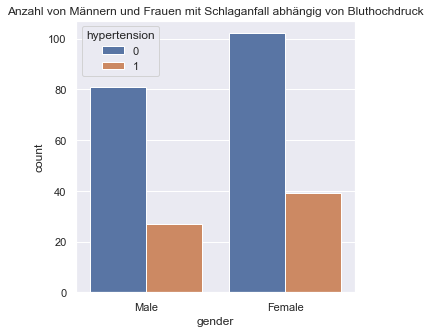

In [29]:
plt.figure(figsize=(5, 5))
hypertension_GenderOnStrokeOnly = sns.countplot(x="gender", hue="hypertension", data=stroke_yes)
hypertension_GenderOnStrokeOnly.set_title("Anzahl von Männern und Frauen mit Schlaganfall abhängig von Bluthochdruck")

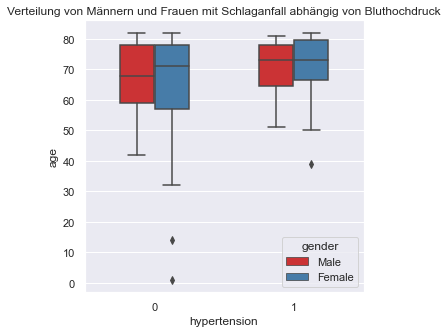

In [30]:
plt.figure(figsize=(5, 5))
hypertension_GenderOnStrokeOnlybox = sns.boxplot(x="hypertension", y="age", hue="gender", data=stroke_yes, palette="Set1", width=0.5)
hypertension_GenderOnStrokeOnlybox.set_title("Verteilung von Männern und Frauen mit Schlaganfall abhängig von Bluthochdruck")
plt.show()

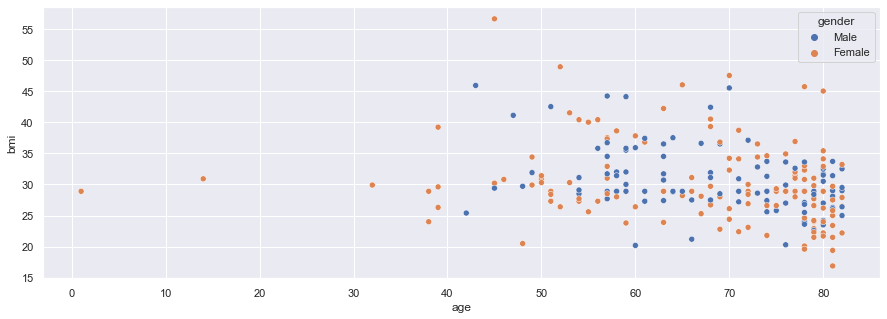

In [31]:
fig = plt.figure(figsize=(15,5))
age_bmiOnStroke = sns.scatterplot(data=stroke_yes, x="age", y="bmi", hue='gender')
plt.show()

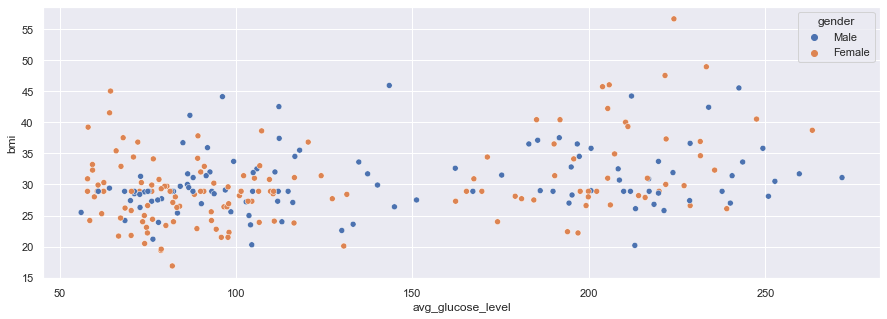

In [32]:
fig = plt.figure(figsize=(15,5))
age_bmiOnStroke = sns.scatterplot(data=stroke_yes, x="avg_glucose_level", y="bmi", hue='gender')
plt.show()

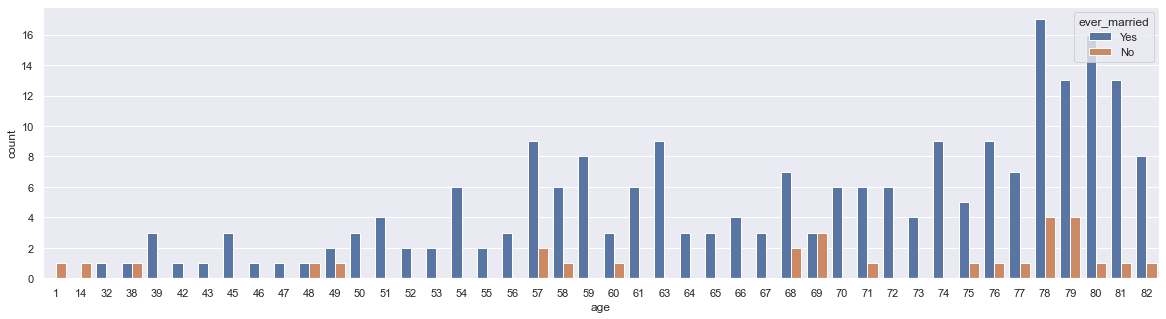

In [33]:
plt.figure(figsize=(20, 5))
mariageOnStroke = sns.countplot(x="age",hue="ever_married", data=stroke_yes)

Yes    220
No      29
Name: ever_married, dtype: int64


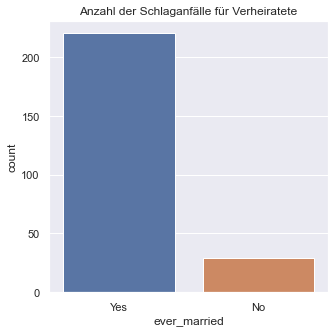

In [34]:
plt.figure(figsize=(5, 5))
mariageOnStroke = sns.countplot(x="ever_married", data=stroke_yes)
mariageOnStroke.set_title("Anzahl der Schlaganfälle für Verheiratete")
print(stroke_yes.ever_married.value_counts())

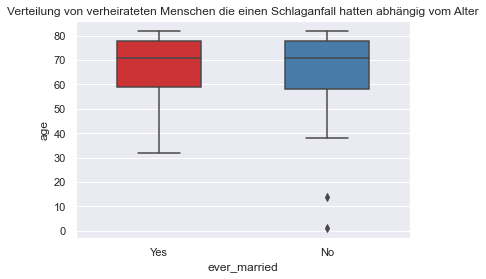

In [35]:
married_age = sns.boxplot(x="ever_married", y="age", data=stroke_yes, palette="Set1", width=0.5)
married_age.set_title("Verteilung von verheirateten Menschen die einen Schlaganfall hatten abhängig vom Alter")
plt.show()

Private          149
Self-employed     65
Govt_job          33
children           2
Name: work_type, dtype: int64


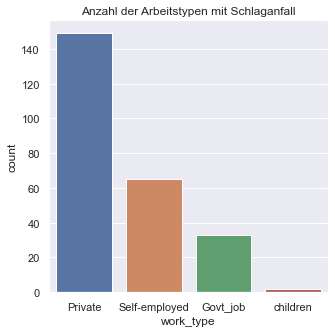

In [36]:
plt.figure(figsize=(5, 5))
work_typeOnStroke = sns.countplot(x="work_type", data=stroke_yes)
print(stroke_yes.work_type.value_counts())
work_typeOnStroke.set_title("Anzahl der Arbeitstypen mit Schlaganfall")
plt.show()

Urban    135
Rural    114
Name: Residence_type, dtype: int64


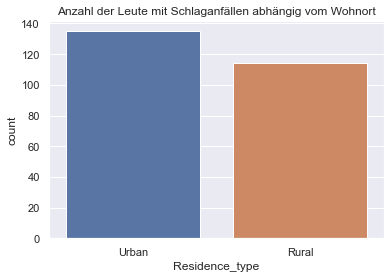

In [37]:
residentOnStroke = sns.countplot(x="Residence_type", data=stroke_yes)
print(stroke_yes.Residence_type.value_counts())
residentOnStroke.set_title("Anzahl der Leute mit Schlaganfällen abhängig vom Wohnort")
plt.show()

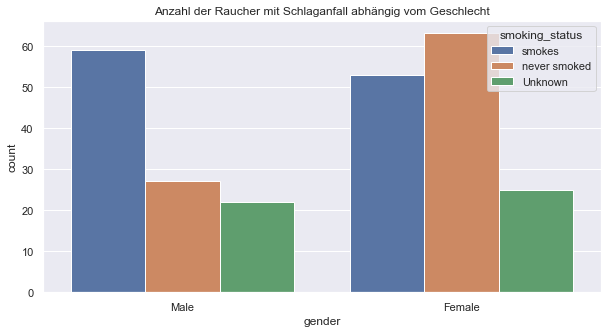

In [38]:
plt.figure(figsize=(10, 5))
smoke = sns.countplot(x="gender",hue="smoking_status", data=stroke_yes)
smoke.set_title("Anzahl der Raucher mit Schlaganfall abhängig vom Geschlecht")
plt.show()

In [39]:
stroke_yes.corr()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
age,1.000000,0.117439,0.154920,0.109000,-0.266042,NaN
hypertension,0.117439,1.000000,0.012607,0.088022,0.050529,NaN
heart_disease,0.154920,0.012607,1.000000,0.247095,0.021212,NaN
avg_glucose_level,0.109000,0.088022,0.247095,1.000000,0.315747,NaN
bmi,-0.266042,0.050529,0.021212,0.315747,1.000000,NaN
stroke,NaN,NaN,NaN,NaN,NaN,NaN


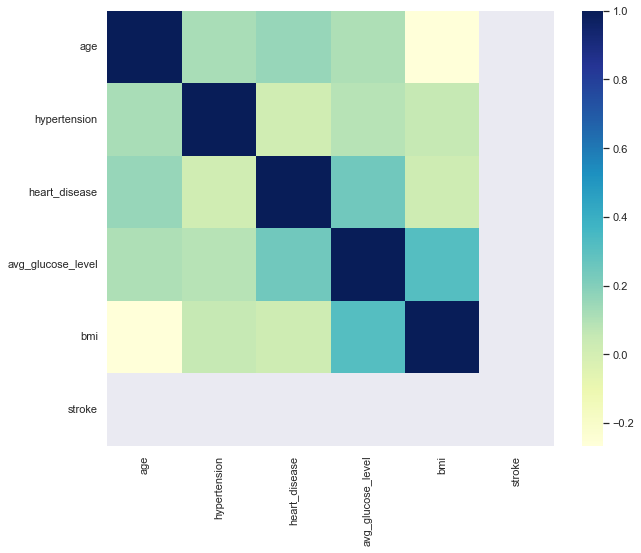

In [40]:
corr = stroke_yes.corr()
f, ax = plt.subplots(figsize=(10, 8))
corr_vis = sns.heatmap(corr,cmap="YlGnBu")
plt.show()

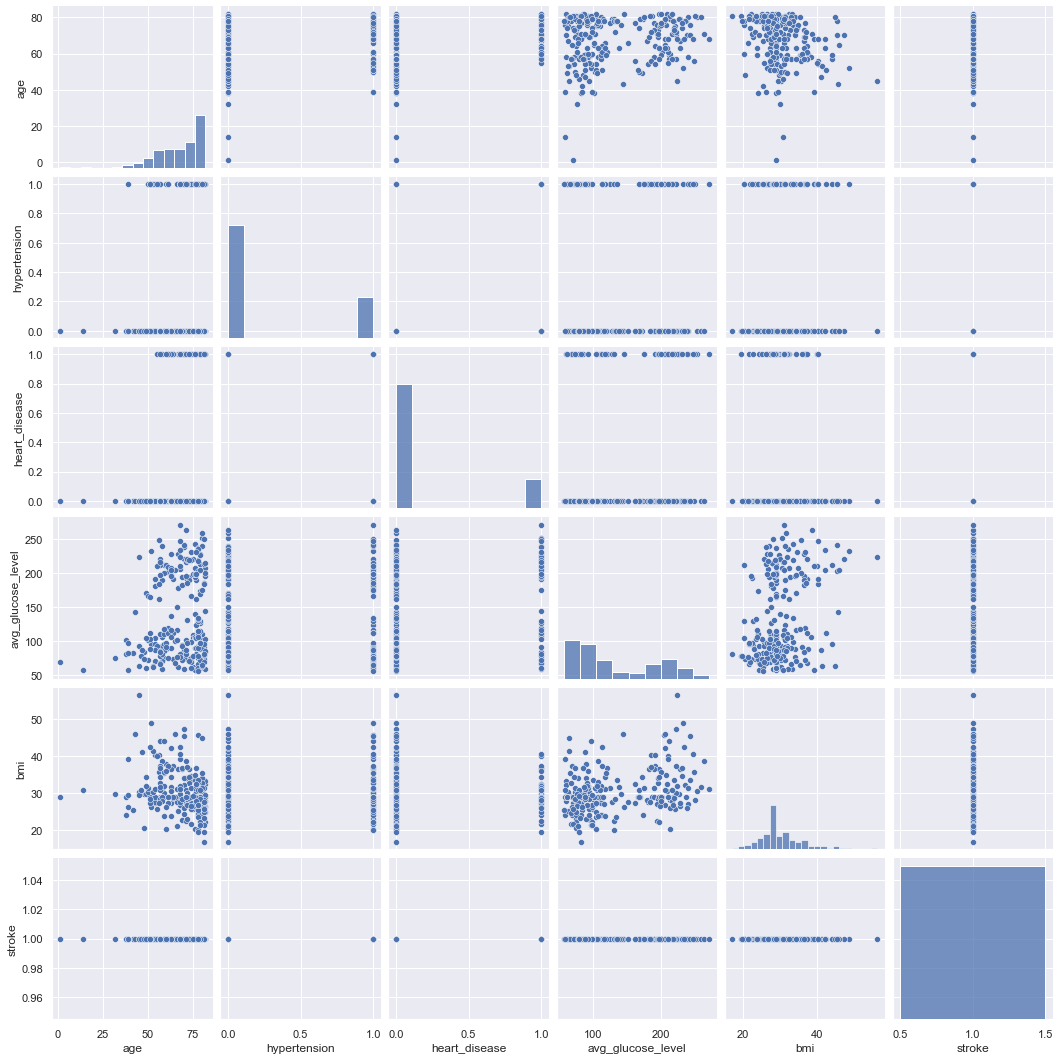

In [41]:
sns.pairplot(stroke_yes)
plt.show()

## Preprocessing

In [42]:
X = df[["age","hypertension","heart_disease","avg_glucose_level","bmi",
        "gender","work_type","Residence_type","ever_married","smoking_status"]]
y = df["stroke"]

### Labelencoding

In [43]:
le = LabelEncoder()
X.loc[:,("Residence_type")] = le.fit_transform(X.loc[:, ("Residence_type")])
X.loc[:,("ever_married")] = le.fit_transform(X.loc[:, ("ever_married")])

/var/folders/r7/3v3ft6690sqbh_jw8gkrtpg10wgcdv/T/ipykernel_53316/2349625803.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:,("Residence_type")] = le.fit_transform(X.loc[:, ("Residence_type")])
/var/folders/r7/3v3ft6690sqbh_jw8gkrtpg10wgcdv/T/ipykernel_53316/2349625803.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:,("ever_married")] = le.fit_transform(X.loc[:, ("ever_married")])


### Dummy-Variablen 


In [44]:
dummy = pd.get_dummies(X[["gender","work_type","smoking_status"]])
dummy

,gender_Female,gender_Male,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_never smoked,smoking_status_smokes
0,0,1,0,0,1,0,0,0,0,1
1,1,0,0,0,0,1,0,0,1,0
2,0,1,0,0,1,0,0,0,1,0
3,1,0,0,0,1,0,0,0,0,1
4,1,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
5105,1,0,0,0,1,0,0,0,1,0
5106,1,0,0,0,0,1,0,0,1,0
5107,1,0,0,0,0,1,0,0,1,0
5108,0,1,0,0,1,0,0,0,0,1


In [45]:
X_concat = pd.concat([X,dummy], axis="columns")

In [48]:
X_encoded = X_concat.drop(["gender","work_type","smoking_status"], axis="columns")
encoded_columns = list(X_encoded.columns)
dump(encoded_columns, "stroke-prediction-columns.joblib")
X_encoded

,age,hypertension,heart_disease,avg_glucose_level,bmi,Residence_type,ever_married,gender_Female,gender_Male,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_never smoked,smoking_status_smokes
0,67,0,1,228.69,36.600000,1,1,0,1,0,0,1,0,0,0,0,1
1,61,0,0,202.21,28.893237,0,1,1,0,0,0,0,1,0,0,1,0
2,80,0,1,105.92,32.500000,0,1,0,1,0,0,1,0,0,0,1,0
3,49,0,0,171.23,34.400000,1,1,1,0,0,0,1,0,0,0,0,1
4,79,1,0,174.12,24.000000,0,1,1,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,80,1,0,83.75,28.893237,1,1,1,0,0,0,1,0,0,0,1,0
5106,81,0,0,125.20,40.000000,1,1,1,0,0,0,0,1,0,0,1,0
5107,35,0,0,82.99,30.600000,0,1,1,0,0,0,0,1,0,0,1,0
5108,51,0,0,166.29,25.600000,0,1,0,1,0,0,1,0,0,0,0,1


### Daten Split und Einfügen von Dummy-Variablen 

In [48]:
train_x, test_x, train_y, test_y = train_test_split(X_encoded, y, test_size=0.3, random_state=10)

In [49]:
print("train x",train_x.shape)
print("train y",train_y.shape)
print("test x",test_x.shape)
print("test y",test_y.shape)

train x (3576, 17)
train y (3576,)
test x (1533, 17)
test y (1533,)


### Oversample 

In [50]:
sm = SMOTE(random_state=27)

samp_x, samp_y = sm.fit_resample(train_x, train_y)

In [51]:
print("Shape before Train_y = 0: ",sum(train_y == 0))
print("Shape before Train_y = 1: ",sum(train_y == 1),"\n")

print("Shape Train_X: ",train_x.shape)
print("Shape Train_y: ",train_y.shape,"\n")

print("Shape Sample Train_X",samp_x.shape)
print("Shape Sample Train_y",samp_y.shape,"\n")

print("Shape after Train_y = 0: ",sum(samp_y == 0))
print("Shape after Train_y = 1: ",sum(samp_y == 1))

Shape before Train_y = 0:  3407
Shape before Train_y = 1:  169 

Shape Train_X:  (3576, 17)
Shape Train_y:  (3576,) 

Shape Sample Train_X (6814, 17)
Shape Sample Train_y (6814,) 

Shape after Train_y = 0:  3407
Shape after Train_y = 1:  3407


## ML Modelle

### Hyperparametersuche (RandomizedSearch) - KNN

In [52]:
knn = KNeighborsClassifier()
param_knn = {"n_neighbors": range(1,100,1),
            "weights": ('uniform', 'distance'),
            "leaf_size": range(1,100,1)}
randomKnn = RandomizedSearchCV(knn, param_knn, scoring="accuracy")
randomKnn.fit(samp_x,samp_y)
print(randomKnn.best_score_)
print(randomKnn.best_estimator_)

0.9261806953866774
KNeighborsClassifier(leaf_size=58, n_neighbors=1)


###  KNN Pipeline und Crossvalidation

In [53]:
pipe = make_pipeline(StandardScaler(),KNeighborsClassifier(algorithm='auto', leaf_size=3, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')
)

In [54]:
cross_val_score(pipe,samp_x, samp_y,cv=5,scoring="accuracy").mean()

0.9534802193054752

In [55]:
pipe.fit(samp_x,samp_y)
knn_predict = pipe.predict(test_x)

In [56]:
print("\t\t[Klassifikationsmetriken]\n\n",classification_report(test_y,knn_predict))
print("[Confusion Matrix]\n\n",confusion_matrix(test_y,knn_predict))

		[Klassifikationsmetriken]

               precision    recall  f1-score   support

           0       0.95      0.96      0.96      1453
           1       0.12      0.09      0.10        80

    accuracy                           0.92      1533
   macro avg       0.53      0.53      0.53      1533
weighted avg       0.91      0.92      0.91      1533

[Confusion Matrix]

 [[1401   52]
 [  73    7]]


### Hyperparametersuche (RandomizedSearch) - Random Forrest

In [57]:
rfc = RandomForestClassifier()
param_rfc = {"n_estimators": range(10,300,10),
            "criterion" : ("gini", "entropy"),
           "max_features" : ("auto", "sqrt", "log2")}
randomRfc = RandomizedSearchCV(rfc,param_rfc,scoring="accuracy")
randomRfc.fit(samp_x, samp_y)
print(randomRfc.best_score_)
print(randomRfc.best_estimator_)

0.9713842769308008
RandomForestClassifier(criterion='entropy', n_estimators=260)


### Random Forest Pipeline und Crossvalidation


In [46]:
pipe = make_pipeline(StandardScaler(), RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=60,
                       n_jobs=None, oob_score=False))

In [ ]:
cross_val_score(pipe,samp_x,samp_y,cv=5,scoring="accuracy").mean()

0.9702113654017495

In [47]:
pipe.fit(samp_x,samp_y)
rf_predict = pipe.predict(test_x)
print("\t\t[Klassifikationsmetriken]\n\n",classification_report(test_y,rf_predict))
print("[Confusion Matrix]\n\n",confusion_matrix(test_y,rf_predict))

		[Klassifikationsmetriken]

               precision    recall  f1-score   support

           0       0.95      1.00      0.97      1453
           1       0.17      0.01      0.02        80

    accuracy                           0.95      1533
   macro avg       0.56      0.50      0.50      1533
weighted avg       0.91      0.95      0.92      1533

[Confusion Matrix]

 [[1448    5]
 [  79    1]]


### Hyperparametersuche (RandomizedSearch) - SVC (Support Vector Classifier)

In [ ]:
svc = SVC()
#param_svc = [{"C": [1,10,100,1000],"kernel" : ['linear']},
            #{"C":[1,10,100,1000], "kernel" : ["rbf"], "gamma": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}]
param_svc = {
    "C" : range(1,100,10),
    "kernel" : ["rbf"],
    "gamma" : [0.6, 0.7, 0.8, 0.9]
}              
randomSvc = RandomizedSearchCV(svc,param_svc,scoring="accuracy")
randomSvc.fit(samp_x,samp_y)
print(randomSvc.best_score_)
print(randomSvc.best_estimator_)

0.9512773606635616
SVC(C=51, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.6, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


### SVC Pipeline und Crossvalidation 

In [48]:
pipe = make_pipeline(StandardScaler(), SVC(C=51, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.6, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False))

In [50]:
cross_val_score(pipe,samp_x,samp_y,cv=5,scoring="accuracy").mean()

0.963162799516916

In [49]:
pipe.fit(samp_x,samp_y)
svc_predict = pipe.predict(test_x)
print("\t\t[Klassifikationsmetriken]\n\n",classification_report(test_y,svc_predict))
print("[Confusion Matrix]\n\n",confusion_matrix(test_y,svc_predict))

		[Klassifikationsmetriken]

               precision    recall  f1-score   support

           0       0.95      0.96      0.95      1453
           1       0.09      0.07      0.08        80

    accuracy                           0.91      1533
   macro avg       0.52      0.52      0.52      1533
weighted avg       0.90      0.91      0.91      1533

[Confusion Matrix]

 [[1392   61]
 [  74    6]]


### Hyperparametersuche (RandomizedSearch) - XGBoost



In [ ]:
xgboost = XGBClassifier()
param_xg = {"max_depth": range(1,20),
            "n_estimators": range(1,500,10)}
              
randomxg = RandomizedSearchCV(xgboost,param_xg,scoring="accuracy")
randomxg.fit(samp_x, samp_y)
print(randomxg.best_score_)
print(randomxg.best_estimator_)

0.9690374842572153
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=211, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


### XGBoost Pipeline und Crossvalidation 

In [51]:
pipe = make_pipeline(StandardScaler(), XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=211, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1))

In [ ]:
cross_val_score(pipe,samp_x,samp_y,cv=5,scoring="accuracy").mean()

0.9677165447644536

In [52]:
pipe.fit(samp_x,samp_y)
xgb_predict = pipe.predict(test_x)
print("\t\t[Klassifikationsmetriken]\n\n",classification_report(test_y,xgb_predict))
print("[Confusion Matrix]\n\n",confusion_matrix(test_y,xgb_predict))

		[Klassifikationsmetriken]

               precision    recall  f1-score   support

           0       0.95      1.00      0.97      1453
           1       0.42      0.06      0.11        80

    accuracy                           0.95      1533
   macro avg       0.68      0.53      0.54      1533
weighted avg       0.92      0.95      0.93      1533

[Confusion Matrix]

 [[1446    7]
 [  75    5]]


### Hyperparametersuche (RandomizedSearch) - MLP Classifier

In [ ]:
mlp = MLPClassifier()

param_mlp = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
    'max_iter': range(1,18)}

randommlp = RandomizedSearchCV(mlp,param_mlp,scoring="accuracy")
randommlp.fit(samp_x, samp_y)
print(randommlp.best_score_)
print(randommlp.best_estimator_)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (230) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (230) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (230) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (93) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/

0.9104799273434798
MLPClassifier(activation='tanh', alpha=0.05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='adaptive',
              learning_rate_init=0.001, max_fun=15000, max_iter=263,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (263) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


### MLPClassifier Pipeline und Crossvalidation

In [53]:
pipe = make_pipeline(StandardScaler(), MLPClassifier(activation='tanh', alpha=0.05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(50,), learning_rate='adaptive',
              learning_rate_init=0.001, max_fun=15000, max_iter=286,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False))

In [ ]:
cross_val_score(pipe,samp_x,samp_y,cv=5,scoring="accuracy").mean()

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (286) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (286) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (286) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (286) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.9380678580008899

In [54]:
pipe.fit(samp_x,samp_y)
mlp_predict = pipe.predict(test_x)
print("\t\t[Klassifikationsmetriken]\n\n",classification_report(test_y,mlp_predict))
print("[Confusion Matrix]\n\n",confusion_matrix(test_y,mlp_predict))

		[Klassifikationsmetriken]

               precision    recall  f1-score   support

           0       0.95      0.95      0.95      1453
           1       0.11      0.10      0.10        80

    accuracy                           0.91      1533
   macro avg       0.53      0.53      0.53      1533
weighted avg       0.91      0.91      0.91      1533

[Confusion Matrix]

 [[1387   66]
 [  72    8]]


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (286) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
